# Proyecto Final: LSTM (Datos Secuenciales)

_Jorge III Altamirano Astorga, Luz Aurora Hernández Martínez, Ita-Andehui Santiago Castillejos._

Tenemos ya los datos sin faltantes con las imputaciones que se han realizado en preparación para tomar estos datos como secuenciales.

Estos datos son una serie de tiempo de:

In [47]:
import re, os, sys, shelve, time, dill
from pickle import PicklingError
from dill import Pickler, Unpickler
shelve.Pickler = Pickler
shelve.Unpickler = Unpickler
from IPython.display import display, Markdown, Math, clear_output, Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, \
  SimpleRNN, Input
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
tf.get_logger().setLevel('ERROR')

try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  from google.colab import files
except:
  ;

base_url = ""
# File Loaders
try:
    base_url = "drive/MyDrive/Colab Notebooks/proyecto-final"
    uploaded = os.path.join(base_url, "data/air-imputated.pickle.gz")
    if(not os.path.isfile(uploaded)):
        from google.colab import files
        uploaded = files.upload()
except:
    uploaded = "air-imputated.pickle.gz"

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    """
    Taken from https://stackoverflow.com/a/39358722/7323086
    """
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w', size=font_size*1.05)
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    plt.show()

#df.dropna(inplace=True)
clear_output()
###########################################
# Restaura todos los objetos del ambiente #
###########################################
def load_h5_models(shelvepath = "drive/MyDrive/Colab Notebooks/proyecto-final/models/"):
  """With this function we try to load the models on the environment (global 
  vars). Whenever possible we use Pickle/Dill within a shelve. Otherwise, for
  tensorflow models.
  """
  h5files = [re.sub("\.h5", "", h5file) for h5file in os.listdir(shelvepath) \
             if h5file.endswith('.h5')]
  for h5file in h5files:
    h5file_ = os.path.join(shelvepath, h5file + ".h5")
    print(f"Loading {h5file_} file...", end=" ")
    try:
      globals()[h5file] = tf.keras.models.load_model(h5file_,
                                                     custom_objects={
                                                         #'KerasLayer': hub.KerasLayer, 
                                                         #'AdamWeightDecay': optimization.AdamWeightDecay
                                                         })
      print("Done!")
    except Exception as e:
      print("Failed!", e)
      raise(e)
  
  shelvefile = [shelve for shelve in os.listdir(shelvepath) \
             if shelve.endswith('.out.db')][0]
  shelvefile = os.path.join(shelvepath, shelvefile)

  print(f"Loading {shelvefile} file...", end=" ")

  shelvefile = re.sub("\.db$", "", shelvefile)
  try:
    my_shelf = shelve.open(shelvefile)
    keys = []
    for key in tqdm(my_shelf):
      try:
        globals()[key] = my_shelf[key]
      except Exception as e:
        if(key != "stopwords"): 
          keys.append(key)
        else:
          raise(e)
    my_shelf.close()
    print("Done!")
    keys = ", ".join(keys)
    if (len(keys) > 0): print(f"(Vars not loaded: {keys})")
  except Exception as e:
    print("Failed!\n", e)
  finally:
    my_shelf.close()
  clear_output()

def performance_plot(history, a=None, b=None, 
                    metrics=["accuracy", "val_accuracy"],
                    plot_validation=True,
                    title="Gráficas de Desempeño."):
  """
  Prints performance plot from a, to b on a history dict.
  
  Inputs:
  history: dict containing "loss" and "accuracy" keys
  a: epoch start
  b. last epoch
  metrics: plot these metrics (train and validation). Always 2.
  plot_validation: boolean indicating if validation data should be plotted.
  a: from this epoch
  b: to this epoch    
  """
  if a is None:
      a = 0
  if b is None:
      b = len(history['loss'])
  a = np.min((a,b))
  b = np.max((a,b))

  imgrows = (len(metrics) + 1) / 2
  imgrows = np.round(imgrows, 0)
  imgrows = int(imgrows)
  #print(imgrows)

  # Plot loss
  plt.figure(figsize=(14, 5
                      *imgrows))
  plt.suptitle(title)
  plt.subplot(imgrows, 2, 1)
  plt.title('Loss')
  plt.plot(history['loss'][a:b], label='Training', linewidth=2)
  if plot_validation:
    plt.plot(history['val_loss'][a:b], label='Validation', linewidth=2)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel(f'Loss')
  quantiles = np.quantile(range(a, b), 
                          [.2, .4, .6, .8]).round(0).astype(int)
  quantiles = np.insert(quantiles, 0, [a])
  quantiles += 1
  quantiles = np.append(quantiles, [b-1])
  plt.xticks(ticks=quantiles-a,
              labels=quantiles)
  plt.grid(True)

  # Plot accuracy
  for i, metric in enumerate(metrics): 
    #print(f"metric: {metric}, i: {i}")
    #print(f"mean metric: {np.mean(history[metric])}")
    plt.subplot(imgrows, 2, i+2)
    plt.title(metric)
    plt.plot(history[metric][a:b], label='Training', 
              linewidth=2)
    if plot_validation:
      plt.plot(history["val_" + metric][a:b], 
                label='Validation', linewidth=2)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    #plt.xlim(a, b)
    #print(range(0, b-a))
    plt.xticks(ticks=quantiles-a, 
                labels=quantiles)
    plt.grid(True)

  plt.show()

#render_mpl_table(df.head().applymap(shorten), col_width=5)

airdata = pd.read_pickle(uploaded)
airdata.head()

,temperature,pressure,humidity,gasResistance,IAQ,iaqAccuracy,datetime,year,month,day,hour,minute,datetime-1,delta,imputated
0,21.51,777.41,44.04,152149.0,34.7,1,2021-02-12 06:05:35.846304417,2021,2,12,6,5,NaT,NaN,False
1,21.51,777.41,43.98,152841.0,33.6,1,2021-02-12 06:05:38.837326527,2021,2,12,6,5,2021-02-12 06:05:35.846304417,2.0,False
2,21.54,777.41,43.73,153259.0,31.5,1,2021-02-12 06:05:47.812360048,2021,2,12,6,5,2021-02-12 06:05:38.837326527,8.0,False
3,21.53,777.41,43.70,152841.0,31.5,1,2021-02-12 06:05:50.803695202,2021,2,12,6,5,2021-02-12 06:05:47.812360048,2.0,False
4,21.52,777.41,43.70,153399.0,30.2,1,2021-02-12 06:05:53.795462847,2021,2,12,6,5,2021-02-12 06:05:50.803695202,2.0,False


In [48]:
Markdown(f"Estso datos son una serie de tiempo de \
{(airdata['datetime'].tail(1).iloc[0] - airdata['datetime'].head(1).iloc[0]).days}\
 días. Con {airdata.shape[0]:3,} observaciones.")

Estso datos son una serie de tiempo de 71 días. Con 2,068,354 observaciones.

In [49]:
Markdown(f"Dichas observaciones fueron \
{airdata['datetime'].head(1).iloc[0]} \
al {airdata['datetime'].tail(1).iloc[0]}.")

Dichas observaciones fueron 2021-02-12 06:05:35.846304417 al 2021-04-24 22:16:20.885603666.

In [50]:
#load_h5_models()

## Preparación de los Datos

Excluimos las columnas del modelo dado que presentan:
* Data leakage: "IAQ", "gasResistance", dado que son la misma variable, 
  transformada; así mismo iaqAccuracy es una variable de la calidad
  de la respuesta.
* Replicabilidad: no se va a repetir la fecha y vamos a buscar predicciones a futuro. Por ende excluimos datetime, year.
* Utilidad: consideramos las siguientes columnas que no son útiles en esta fase: datetime-1, imputated.


### Separación de Sets Entrenamiento, Pruebas

Separamos los sets  de entrenamiento  y pruebas para evaluar los modelos que realizamos.

In [51]:
excluded_columns = ["iaqAccuracy", "datetime", "datetime-1", "delta", 
                    "imputated", "year"]
train, test = train_test_split(airdata[[x 
                                        for x in airdata.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.8, random_state=175904, shuffle=False)
display(Markdown(f"* Observaciones en el set de entrenamiento: \
{train.shape[0]:3,} ({100*train.shape[0]/airdata.shape[0]:.2f}%)."))
display(Markdown(f"* Observaciones en el set de pruebas: \
{test.shape[0]:3,} ({100*test.shape[0]/airdata.shape[0]:.2f}%)."))

* Observaciones en el set de entrenamiento: 1,654,683 (80.00%).

* Observaciones en el set de pruebas: 413,671 (20.00%).

### Escalamos los Datos

In [52]:
scaler = MinMaxScaler()
scaler_f = scaler.fit(train)
train2 = scaler_f.transform(train)
test2 = scaler_f.transform(test)
X_cols = [i for i, x in enumerate(train.columns) 
          if x not in ["IAQ", "gasResistance"]]
Y_cols = [i for i, x in enumerate(train.columns) 
          if x in ["IAQ", "gasResistance"]]
X_train = train2[:, X_cols]
Y_train = train2[:, Y_cols]
X_test  = test2[:, X_cols]
Y_test = test2[:, Y_cols]
display(
    Markdown(f"X_train.shape = {X_train.shape}, Y_train.shape = {Y_train.shape}."
    )
)
display(
    Markdown(f"X_test.shape = {X_test.shape}, Y_test.shape = {Y_test.shape}."
    )
)

X_train.shape = (1654683, 7), Y_train.shape = (1654683, 2).

X_test.shape = (413671, 7), Y_test.shape = (413671, 2).

In [53]:
def train_model(model, train_data,  validation_data,
                epochs=10, batch_size=512, 
                steps_per_epoch=100, loss='mse', optimizer='adam', 
                metrics=['mse'], verbose=0, base_dir=""):
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  cbk = TqdmCallback()
  tiempo = time.time()
  history = model.fit(train_data, validation_data=validation_data,
                      epochs=epochs, steps_per_epoch=steps_per_epoch, 
                      batch_size=batch_size, verbose=verbose, callbacks=[cbk])
  clear_output()
  tiempo = time.time() - tiempo
  print(f"Tiempo de procesamiento: {tiempo:.2f} segundos.")

  #### Guardar el modelo
  base_dir = os.path.join(base_url, "models", model.name)
  model.save(f"{base_dir}.h5")
  dill.dump(tiempo, open(f"{base_dir}.time.dill", 'wb'))
  dill.dump(history.history, open(f"{base_dir}.hist.dill", 'wb'))
  #### fin sección guardar modelo

  return history

# sampling_rate: 3 seconds per sample
sampling_rate = 3
# 1 hours * minutes * seconds / sampling_rate in seconds
past = int(1 * 60 * 60 / sampling_rate) 
#display(f"X_train shape = {X_train.shape}")
train3_gas = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train,
  sequence_length=past,
  sampling_rate=sampling_rate,
  batch_size=512,
  seed=175904
)
train3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train, 
  Y_train,
  sequence_length=past,
  sampling_rate=sampling_rate,
  batch_size=512,
  seed=175904
)
test3_gas = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test,
  sequence_length=past,
  sequence_stride=60*60,
  sampling_rate=60,
  batch_size=512,
  seed=175904
)
test3_iaq = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_test, 
  Y_test,
  sequence_length=past,
  sequence_stride=60*60,
  sampling_rate=60,
  batch_size=512,
  seed=175904
)

## Creación del Modelo 00 con Variable gasResistance

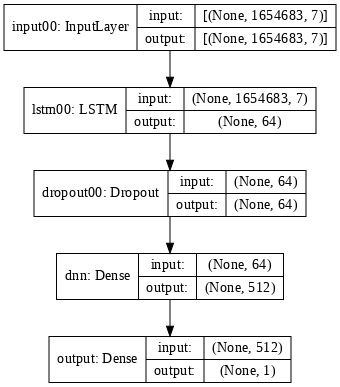

In [54]:
model_lstm00 = Sequential(name="model_lstm00")
model_lstm00.add(Input(shape=(X_train.shape[0], X_train.shape[1], ), 
                       name="input00"))
model_lstm00.add(LSTM(units=64, name="lstm00"))
model_lstm00.add(Dropout(0.5, name="dropout00"))
model_lstm00.add(Dense(units=512, activation='relu', name="dnn"))
model_lstm00.add(Dense(units=1, activation=None, name="output"))
plot_model(model_lstm00, to_file=os.path.join(base_url, "data/model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [55]:
trained_lstm00 = train_model(model_lstm00, train3_gas,
                            validation_data=test3_gas,
                            metrics=["mse", "mae", "mean_squared_logarithmic_error"],
                            epochs=100, steps_per_epoch=40, 
                            base_dir=base_url)

Tiempo de procesamiento: 539.90 segundos.


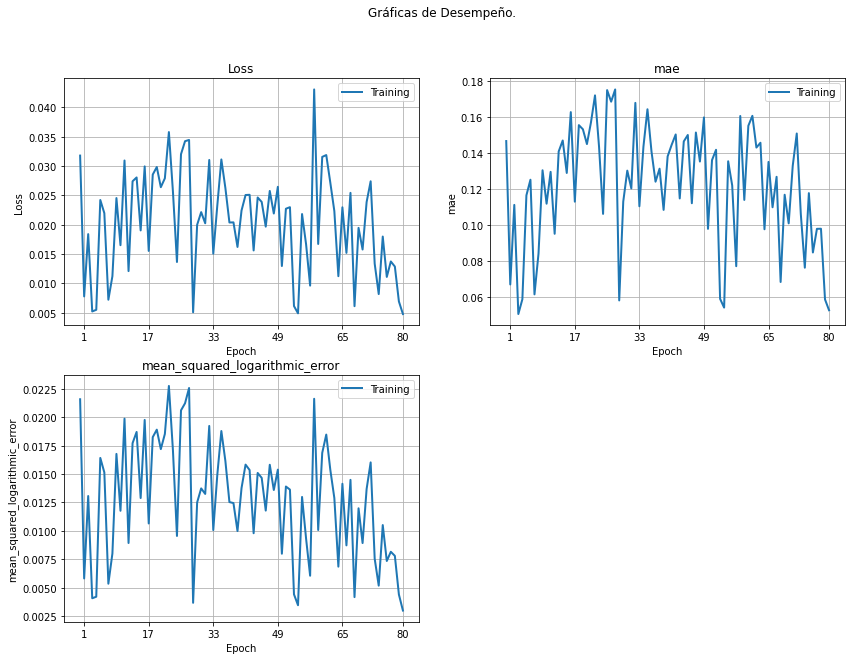

In [56]:
performance_plot(trained_lstm00.history, metrics=["mae", "mean_squared_logarithmic_error"], 
                 plot_validation=False)

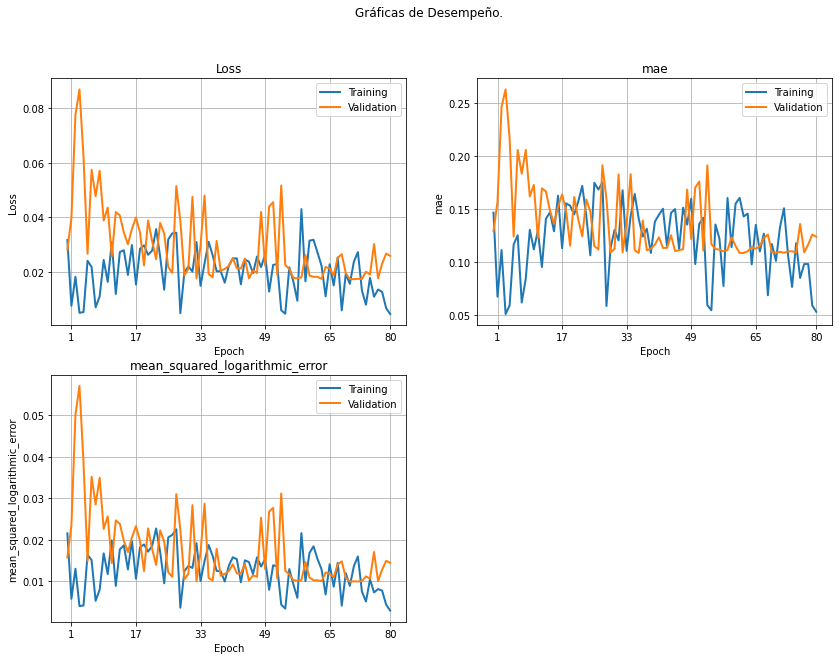

In [57]:
performance_plot(trained_lstm00.history, metrics=['mae', "mean_squared_logarithmic_error"])

## Creación del Modelo 00 Variable IAQ

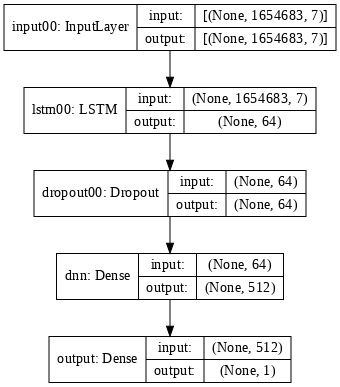

In [58]:
model_lstm01 = Sequential(name="model_lstm01")
model_lstm01.add(Input(shape=(X_train.shape[0], X_train.shape[1], ), 
                       name="input00"))
model_lstm01.add(LSTM(units=64, name="lstm00"))
model_lstm01.add(Dropout(0.5, name="dropout00"))
model_lstm01.add(Dense(units=512, activation='relu', name="dnn"))
model_lstm01.add(Dense(units=1, activation=None, name="output"))
plot_model(model_lstm01, to_file=os.path.join(base_url, "data/model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [59]:
trained_lstm01 = train_model(model_lstm01, train3_gas,
                            validation_data=test3_gas,
                            metrics=["mse", "mae", "mean_squared_logarithmic_error"],
                            epochs=100, steps_per_epoch=5, 
                            base_dir=base_url)

Tiempo de procesamiento: 99.60 segundos.


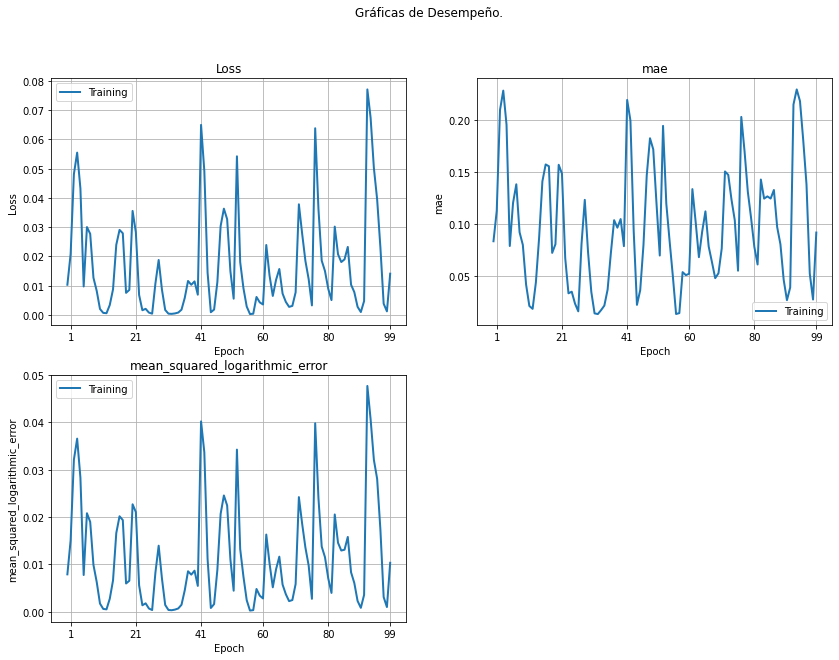

In [60]:
performance_plot(trained_lstm01.history, metrics=["mae", "mean_squared_logarithmic_error"], 
                 plot_validation=False)

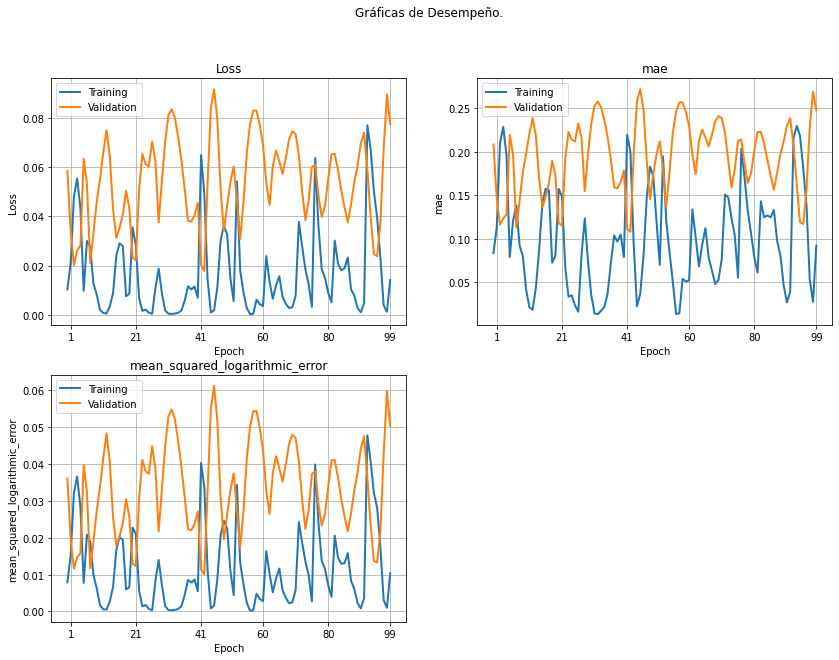

In [61]:
performance_plot(trained_lstm01.history, metrics=['mae', "mean_squared_logarithmic_error"])

## Creación del Modelo 01 con Variable gasResistance

Introducimos un modelo mucho más complejo

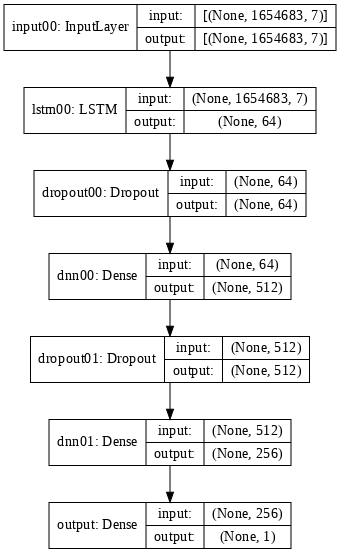

In [62]:
model_lstm02 = Sequential(name="model_lstm02")
model_lstm02.add(Input(shape=(X_train.shape[0], X_train.shape[1], ), 
                       name="input00"))
model_lstm02.add(LSTM(units=64, name="lstm00"))
model_lstm02.add(Dropout(0.2, name="dropout00"))
model_lstm02.add(Dense(units=512, activation='relu', name="dnn00"))
model_lstm02.add(Dropout(0.2, name="dropout01"))
model_lstm02.add(Dense(units=256, activation='relu', name="dnn01"))
model_lstm02.add(Dense(units=1, activation=None, name="output"))
plot_model(model_lstm02, to_file=os.path.join(base_url, "data/model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [63]:
trained_lstm02 = train_model(model_lstm02, train3_gas,
                            validation_data=test3_gas,
                            metrics=["mse", "mae", "mean_squared_logarithmic_error"],
                            epochs=100, steps_per_epoch=40, 
                            base_dir=base_url)

Tiempo de procesamiento: 544.88 segundos.


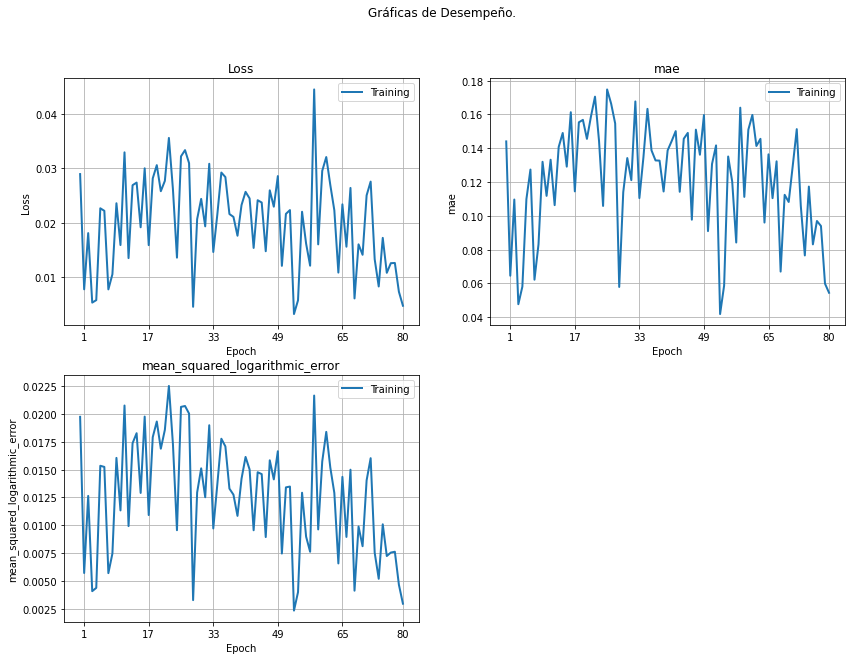

In [64]:
performance_plot(trained_lstm02.history, metrics=["mae", "mean_squared_logarithmic_error"], 
                 plot_validation=False)

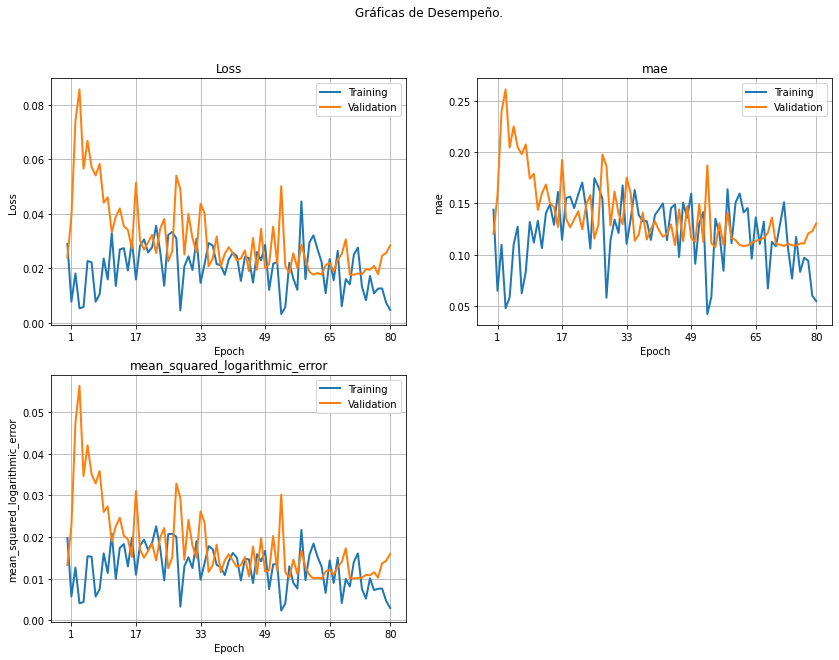

In [65]:
performance_plot(trained_lstm02.history, metrics=['mae', "mean_squared_logarithmic_error"])

## Creación del Modelo 01 Variable IAQ

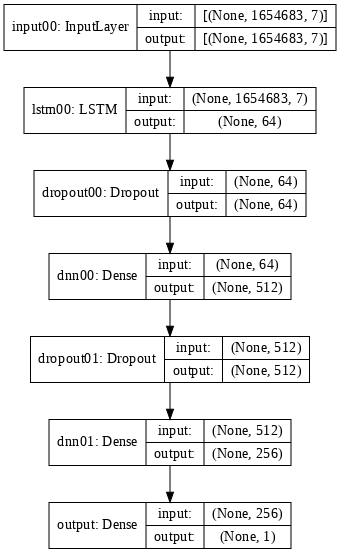

In [66]:
model_lstm03 = Sequential(name="model_lstm03")
model_lstm03.add(Input(shape=(X_train.shape[0], X_train.shape[1], ), 
                       name="input00"))
model_lstm03.add(LSTM(units=64, name="lstm00"))
model_lstm03.add(Dropout(0.2, name="dropout00"))
model_lstm03.add(Dense(units=512, activation='relu', name="dnn00"))
model_lstm03.add(Dropout(0.2, name="dropout01"))
model_lstm03.add(Dense(units=256, activation='relu', name="dnn01"))
model_lstm03.add(Dense(units=1, activation=None, name="output"))
plot_model(model_lstm03, to_file=os.path.join(base_url, "data/model.png"), 
           dpi=72, rankdir="TD", show_shapes=True, expand_nested=True)

In [67]:
trained_lstm03 = train_model(model_lstm03, train3_gas,
                            validation_data=test3_gas,
                            metrics=["mse", "mae", "mean_squared_logarithmic_error"],
                            epochs=100, steps_per_epoch=40, 
                            base_dir=base_url)

Tiempo de procesamiento: 544.29 segundos.


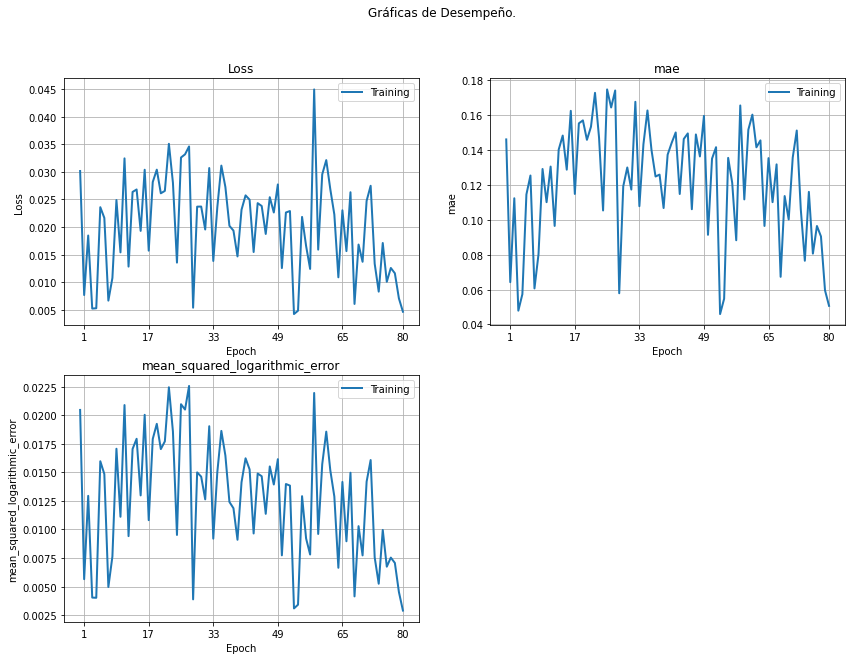

In [68]:
performance_plot(trained_lstm03.history, metrics=["mae", "mean_squared_logarithmic_error"], 
                 plot_validation=False)

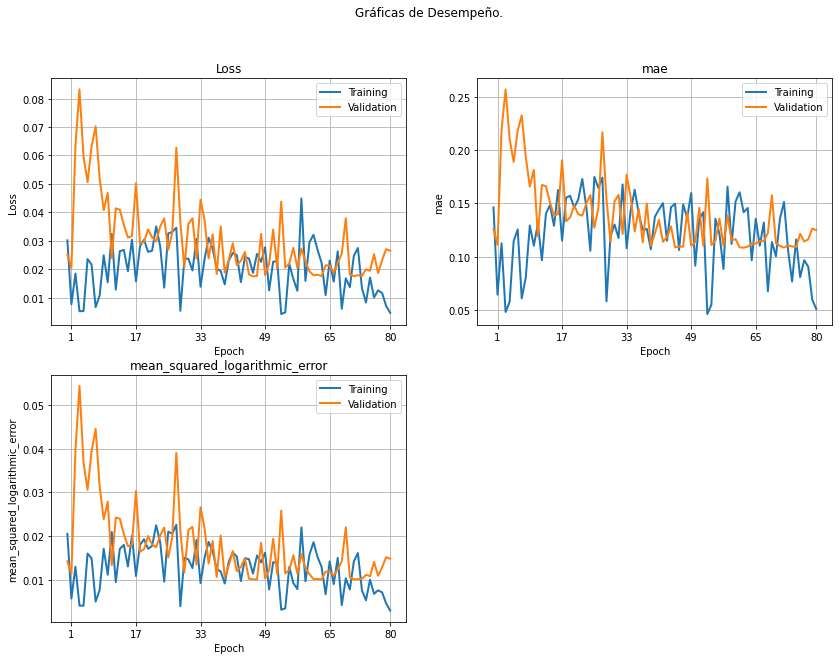

In [69]:
performance_plot(trained_lstm03.history, metrics=['mae', "mean_squared_logarithmic_error"])

# Referencias

* Keras contributors et al. [Keras / Code examples / Timeseries / Timeseries forecasting for weather prediction](https://keras.io/examples/timeseries/timeseries_weather_forecasting/). 2021.

* Tensorflow Contributors. [Tensorflow: Tutorial on Time series forecastingTime series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_serieshttps://www.tensorflow.org/tutorials/structured_data/time_series). 2021.

* Román-Rangel, Francisco. Notas y Código del Curso de Aprendizaje Profundo. 2021.

* González-Pérez, Felipe. [Notas de aprendizaje de máquina (2020)](https://lucid-torvalds-517e78.netlify.app/)

* Keras contributors et al. [Keras API Reference: fit](https://keras.rstudio.com/reference/fit.html). 2021.

* Keras contributors et al. [Keras API Reference: train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). 2021.

* Keras contributors et al. [Keras API Reference: timeseries_dataset_from_array](https://keras.io/api/preprocessing/timeseries/). 2021.